# R4 on ISIC 2019

In [ ]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
import abstract_gradient_training as agt
from abstract_gradient_training import certified_training_utils as ct_utils
from models.R4_models import LesionNet
from models.pipeline import (train_model_with_certified_input_grad, train_model_with_pgd_robust_input_grad, write_results_to_file,
                             load_params_or_results_from_file, test_model_avg_and_wg_accuracy, train_model_with_smoothed_input_grad,
                             test_model_accuracy, test_delta_input_robustness, test_model_avg_and_wg_accuracy)
from metrics import (get_restart_avg_and_worst_group_accuracy_with_stddev, get_restart_macro_avg_acc_over_labels_with_stddev)
from datasets import isic

### Note: for ISIC, we need to separately calculate the macro averaged accuracy over the LABELS, because the groups differ from the labels in this dataset, i.e.: labels are 0 and 1 (benign and malignant), while the groups are 0, 1 and 2 representing ("cancer", "no patch no cancer" and "patch no cancer").

# Get the dataloaders 

In [16]:
CUDA_LAUNCH_BLOCKING=1
SEED = 0
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)

cuda:1


In [17]:
DATA_ROOT = "/vol/bitbucket/mg2720/isic/"

isic_train = isic.ISICDataset(DATA_ROOT, is_train=True)
isic_test = isic.ISICDataset(DATA_ROOT, is_train=False)
isic_test_grouped = isic.ISICDataset(DATA_ROOT, is_train=False, grouped=True)
img, lbl, mask = isic_train[1]
train_pos, train_neg = (isic_train.labels == 1).sum(), (isic_train.labels == 0).sum()
print(f"Train: {train_pos} positive, {train_neg} negative")

Train: 2059 positive, 15773 negative


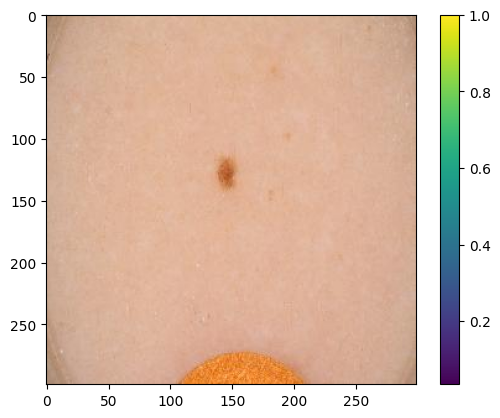

torch.Size([3, 299, 299]) tensor(55637.9648)


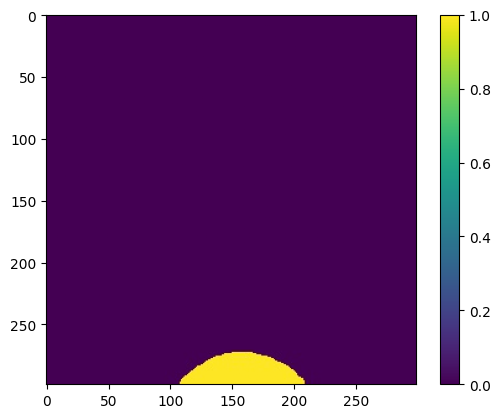

In [18]:
idx = 0
for i in range(len(isic_train)):
    img, lbl, mask = isic_train[i]
    if mask.sum() > 0:
        idx = i
        break
plt.imshow(img.permute(1, 2, 0).squeeze().numpy())
plt.colorbar()
plt.show()
print(mask.shape, mask.sum())
plt.imshow(mask.permute(1, 2, 0).squeeze().numpy())
plt.colorbar()

In [19]:
batch_size = 256
dl_train = isic.get_loader_from_dataset(isic_train, batch_size=batch_size, shuffle=False)
dl_test = isic.get_loader_from_dataset(isic_test, batch_size=batch_size, shuffle=False)
dl_test_grouped = isic.get_loader_from_dataset(isic_test_grouped, batch_size=batch_size, shuffle=False)

In [20]:
model = LesionNet(3, 1)
criterion = torch.nn.BCELoss()
model = model.to(device)
torch.backends.cudnn.deterministic = True

## Experiments 

In [21]:
DELTA_INPUT_ROBUSTNESS_PARAM = 1
model_root_save_dir = "saved_experiment_models/performance/isic"
os.makedirs(model_root_save_dir, exist_ok=True)
methods = ["r4", "pgd_r4", "std", "smooth_r3", "rand_r4", "ibp_ex", "ibp_ex+r3", "r3"]
save_dir_for_method = {method: os.path.join(model_root_save_dir, method) for method in methods}
for method in methods:
    os.makedirs(save_dir_for_method[method], exist_ok=True)

### Standard Training

In [ ]:
std_method = "std"
# hyperparameters
class_weights = [1, 9]
num_epochs, lr, restarts, epsilon, weight_coeff, k = 8, 0.0003, 3, 0.1, -1, -1
# Train standard 3 times and test accuracy and delta input robustness for the masked region
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = LesionNet(3, 1).to(device)

    print(f"========== Training model with method {std_method} restart {i} ==========")
    train_model_with_certified_input_grad(
        dl_train, num_epochs, curr_model, lr, criterion, epsilon, std_method, k, device, True, class_weights = class_weights
    )
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test_grouped, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(
        dl_test_grouped, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "binary_cross_entropy", device, has_conv=True
    )
    num_robust += num_robust
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_test_grouped, device, num_groups=3)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[std_method], f"run_{i}.pt"))
empty_model = LesionNet(3, 1).to(device)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_test_grouped, save_dir_for_method[std_method], empty_model, device, num_groups=3
)
macro_avg_over_labels, _ = get_restart_macro_avg_acc_over_labels_with_stddev(
    dl_test_grouped, save_dir_for_method[std_method], empty_model, device
)
write_results_to_file("experiment_results/isic.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "macro_avg_over_labels": round(macro_avg_over_labels, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, std_method)
write_results_to_file("experiment_results/isic_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_train.batch_size,
                         "test_batch_size": dl_train.batch_size,
                         "class_weights": class_weights,
                         "multi_class": False,
                         "has_conv": True,
                         "with_k_schedule": False}, std_method)

========== Training model with method std restart 0 ==========


Epoch: 100%|██████████| 8/8 [16:50<00:00, 126.25s/it, loss=0.643, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.7656
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.7663
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 0.421
--- Model accuracy per group ---
Macro average group accuracy = 0.8103
Min group accuracy = 0.5372, group idx = 1
========== Training model with method std restart 1 ==========


Epoch: 100%|██████████| 8/8 [08:14<00:00, 61.86s/it, loss=0.711, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.7358
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.738
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 0.406
--- Model accuracy per group ---
Macro average group accuracy = 0.803
Min group accuracy = 0.4746, group idx = 1
========== Training model with method std restart 2 ==========


Epoch: 100%|██████████| 8/8 [08:11<00:00, 61.41s/it, loss=0.737, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.763
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.7649
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 0.443
--- Model accuracy per group ---
Macro average group accuracy = 0.814
Min group accuracy = 0.5306, group idx = 1
Macro average group accuracy = 0.8091
Min group accuracy = 0.5141, group idx = 1
Group accuracies averaged over run = tensor([0.9220, 0.5141, 0.9911], dtype=torch.float64)


### RRR Training

In [ ]:
rrr_method = "r3"
# hyperparameters
class_weights = [1, 9]
num_epochs, lr, restarts, epsilon, weight_coeff, k = 5, 0.0004, 1, 0.1, 0.0001, 1
# Train standard 3 times and test accuracy and delta input robustness for the masked region
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = LesionNet(3, 1).to(device)

    print(f"========== Training model with method {rrr_method} restart {i} ==========")
    train_model_with_certified_input_grad(
        dl_train, num_epochs, curr_model, lr, criterion, epsilon, rrr_method, k, device, True, class_weights = class_weights
    )
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test_grouped, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(
        dl_test_grouped, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "binary_cross_entropy", device, has_conv=True
    )
    num_robust += num_robust
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_test_grouped, device, num_groups=3)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[rrr_method], f"run_{i}.pt"))
empty_model = LesionNet(3, 1).to(device)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_test_grouped, save_dir_for_method[rrr_method], empty_model, device, num_groups=3
)
write_results_to_file("experiment_results/isic.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, rrr_method)
write_results_to_file("experiment_results/isic_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_train.batch_size,
                         "test_batch_size": dl_train.batch_size,
                         "class_weights": class_weights,
                         "multi_class": False,
                         "has_conv": True,
                         "with_k_schedule": False}, rrr_method)

In [ ]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = LesionNet(3, 1).to(device)

    print(f"========== Training model with method R4, restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, r4_method, k, has_conv=True)
    test_model_acc(curr_model)
    test_delta_input_robustness(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize, has_conv=True)